# Logistic YoloV8 for detecting numberplates of vehicles and encrypting them for ensuring security

## Used Pretrained model

* YoloV8

## Configuration of the local machine

| Component Category | Specific model   |
|---|---|
| CPU  | Ryzen 5 3500X 6 Core, 6 Threads   |
| RAM  |  24GB DDR4 3200 BUS  |
| GPU  | Nvidia GeForce RTX 3050 8GB GDDR6  |
| Storage | 240 GB SSD|

### Check if Nvidia-SMI is working

In [1]:
!nvidia-smi

Sat Dec  2 00:29:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050        Off | 00000000:07:00.0  On |                  N/A |
|  0%   43C    P8               9W / 130W |    279MiB /  8192MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Check if CUDA is working

In [2]:
import torch
print(torch.cuda.is_available())

True


#### Check the current directory files/folders

In [3]:
!ls

dataset  Logistic_YoloV8.ipynb	requirements.txt  ultralytics
LICENSE  README.md		runs


### Install every required pacakges and modules from `requirements.txt`

In [4]:
!pip install -r requirements.txt

## Apply 50 epochs to train the model

In [5]:
!python3 /home/fahim/Desktop/encrypted-image-for-vehicles/ultralytics/yolo/v8/detect/train.py model=yolov8n.pt data=/home/fahim/Desktop/encrypted-image-for-vehicles/dataset/data.yaml epochs=50

100%|██████████████████████████████████████| 6.23M/6.23M [00:04<00:00, 1.54MB/s]

yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/fahim/Desktop/encrypted-image-for-vehicles/dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, retina_masks=False, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17

### Testing an external image (labeling)

In [16]:
!python3 ultralytics/yolo/v8/detect/predict.py model='/home/fahim/Desktop/encrypted-image-for-vehicles/runs/detect/train/weights/best.pt' source='/home/fahim/Desktop/encrypted-image-for-vehicles/external_images/hyundai-eon-busted.jpg' save_txt=True

Ultralytics YOLOv8.0.3 🚀 Python-3.11.5 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 3050, 7965MiB)
Fusing layers... 
Model summary: 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
image 1/1 /home/fahim/Desktop/encrypted-image-for-vehicles/external_images/hyundai-eon-busted.jpg: 352x640 2 License_Plates, 69.4ms
Speed: 0.3ms pre-process, 69.4ms inference, 318.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train2
1 labels saved to runs/detect/train2/labels


### Generating various plots, images, etc.

In [17]:
from PIL import Image, ImageDraw
import numpy as np
from IPython.display import display, Image as IPImage

### Logistic Map for generating the key during encryption. It is also used to read the folder.

In [18]:
def logistic_map(r, x):
    return r * x * (1 - x)

def generate_key(seed, n):
    key = []
    x = seed
    for _ in range(n):
        x = logistic_map(3.9, x)
        key.append(x)
    return key

def read_bb_coordinates(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        coordinates_list = [tuple(map(float, line.strip().split()[1:])) for line in lines]
        return coordinates_list

### Encrypting the image

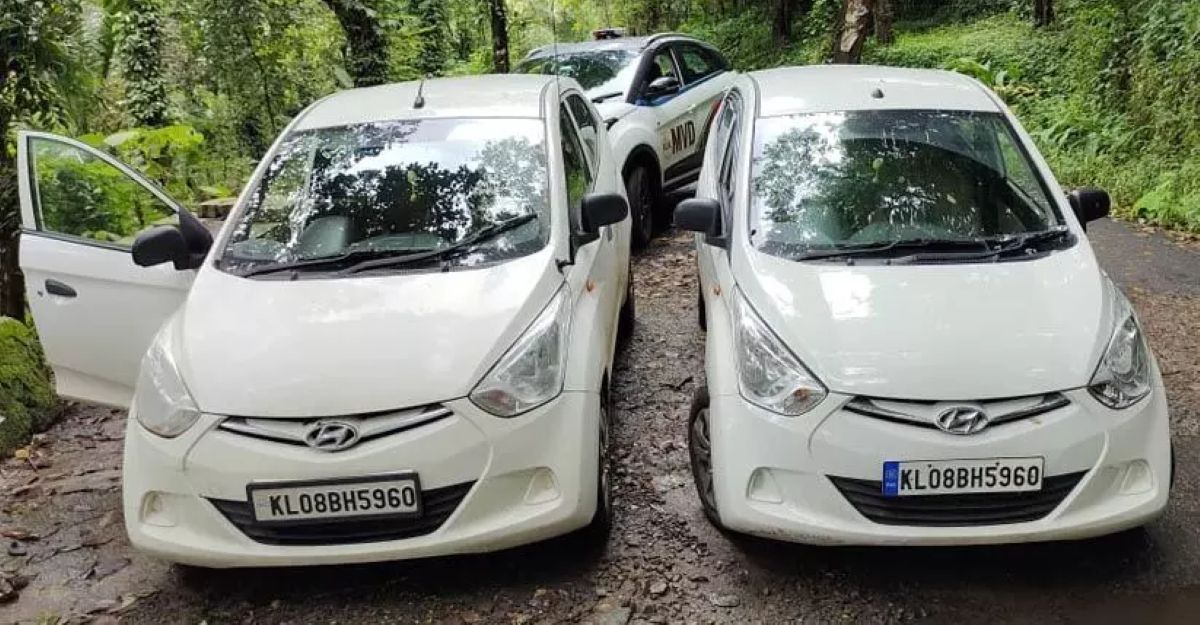

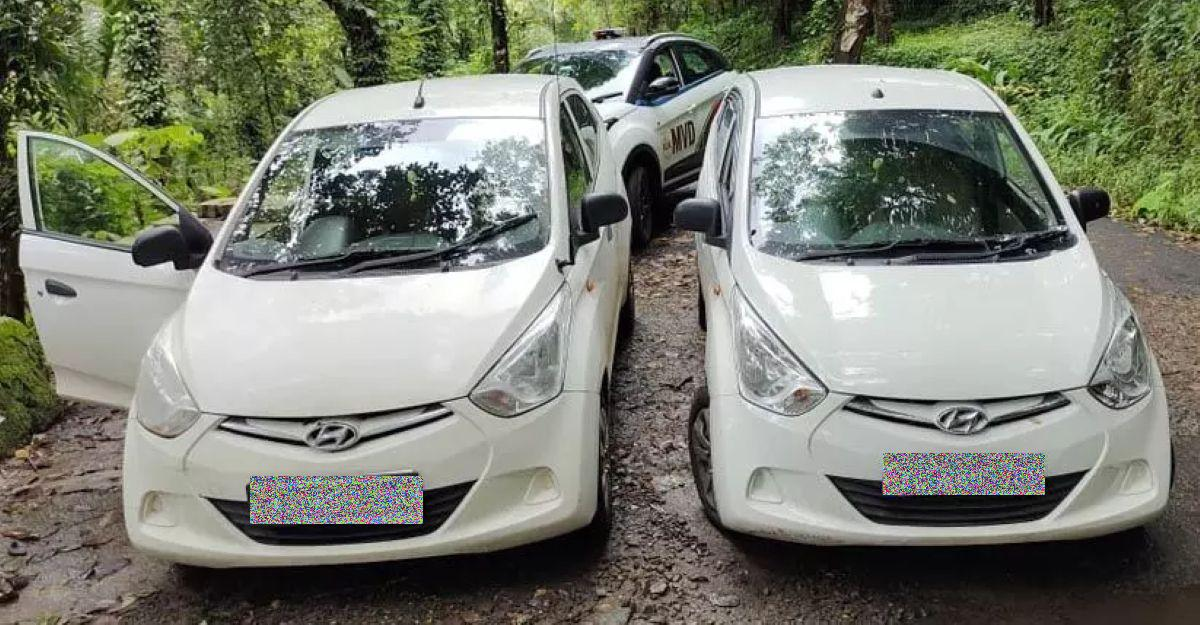

In [19]:
def encrypt(input_path, output_path, key_seed, bounding_boxes, expansion_factor=0.3):
    img = Image.open(input_path)
    img_array = np.array(img)

    for bounding_box in bounding_boxes:
        h, w, seed = img_array.shape
        center_x, center_y, width, height = bounding_box
        x1 = int((center_x - width/2) * w)
        y1 = int((center_y - height/2) * h)
        x2 = int((center_x + width/2) * w)
        y2 = int((center_y + height/2) * h)

        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

        license_plate = img_array[y1:y2, x1:x2]

        flat_license_plate = license_plate.flatten()

        chaotic_key = generate_key(key_seed, len(flat_license_plate))
        encrypted_region = [pixel ^ int(chaotic_key[i] * 255) for i, pixel in enumerate(flat_license_plate)]

        encrypted_region = np.array(encrypted_region).reshape(license_plate.shape)

        img_array[y1:y2, x1:x2] = encrypted_region


    encrypted_img = Image.fromarray(img_array.astype(np.uint8))
    encrypted_img.save(output_path)

def display_image(image_path):
    img = Image.open(image_path)
    display(IPImage(data=image_path))



input_image_path = '/home/fahim/Desktop/encrypted-image-for-vehicles/external_images/hyundai-eon-busted.jpg'
encrypted_image_path = "encrypted_license_plate_image_new_model.jpg"
key_seed = 0.1

bounding_box_file_path = "/home/fahim/Desktop/encrypted-image-for-vehicles/runs/detect/train2/labels/hyundai-eon-busted.txt"
bounding_boxes = read_bb_coordinates(bounding_box_file_path)

encrypt(input_image_path, encrypted_image_path, key_seed, bounding_boxes, expansion_factor=0.3)

display_image(input_image_path)

display_image(encrypted_image_path)


### Running the test folder data

In [20]:
!python3 ultralytics/yolo/v8/detect/predict.py model='/home/fahim/Desktop/encrypted-image-for-vehicles/runs/detect/train/weights/best.pt' source='/home/fahim/Desktop/encrypted-image-for-vehicles/dataset/test/images/' save_txt=True

Ultralytics YOLOv8.0.3 🚀 Python-3.11.5 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 3050, 7965MiB)
Fusing layers... 
Model summary: 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
image 1/882 /home/fahim/Desktop/encrypted-image-for-vehicles/dataset/test/images/0002a5b67e5f0909_jpg.rf.faf1b011433d7eefbc249c76e730e2aa.jpg: 480x640 2 License_Plates, 69.8ms
image 2/882 /home/fahim/Desktop/encrypted-image-for-vehicles/dataset/test/images/000812dcf304a8e7_jpg.rf.741086a8d62208565e67c3cf9cfe2259.jpg: 576x640 1 License_Plate, 70.2ms
image 3/882 /home/fahim/Desktop/encrypted-image-for-vehicles/dataset/test/images/0010f4c10f7ab07e_jpg.rf.68d81164c12015d8ce813ef5afe1c55b.jpg: 480x640 2 License_Plates, 4.6ms
image 4/882 /home/fahim/Desktop/encrypted-image-for-vehicles/dataset/test/images/001cdd25e148cd36_jpg.rf.e6d7404f6eeff0ea4e68989f94d2db29.jpg: 480x640 1 License_Plate, 4.3ms
image 5/882 /home/fahim/Desktop/encrypted-image-for-vehicles/dataset/test/images/002519f868563098_jpg.rf.aed617724276e

## Confusion Matrix

In [22]:
# Importing libraries for generating the confusion matrix

from sklearn.metrics import confusion_matrix

Number of correct detections: 811
Precision: 0.89121
Recall: 0.89911
F1 Score: 0.89514
True Positives (TP): 811
False Positives (FP): 99
False Negatives (FN): 91
Accuracy: 0.82601


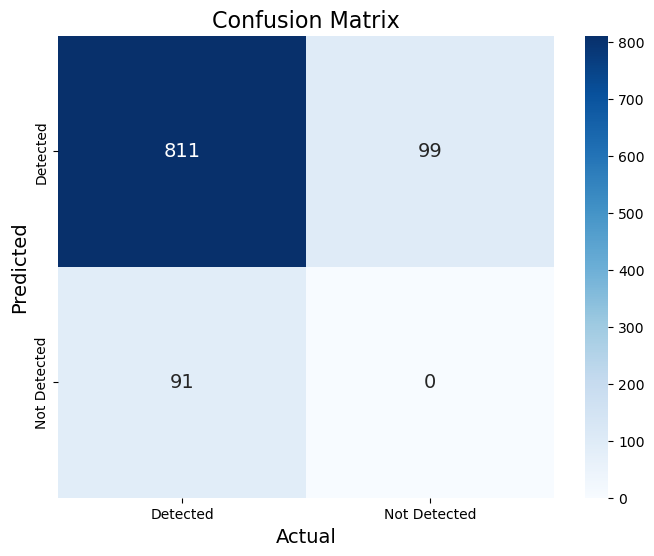

In [23]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate IoU
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area
    return iou


def load_boxes_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        bounding_boxes = [list(map(float, line.strip().split()[1:])) for line in lines]

    return bounding_boxes


def convert_to_absolute(box, image_width, image_height):
    x, y, w, h = box
    abs_x = int((x - w/2) * image_width)
    abs_y = int((y - h/2) * image_height)
    abs_w = int(w * image_width)
    abs_h = int(h * image_height)
    return abs_x, abs_y, abs_x + abs_w, abs_y + abs_h


# Paths to label files
true_boxes_path = '/home/fahim/Desktop/encrypted-image-for-vehicles/dataset/test/labels'
predicted_boxes_path = '/home/fahim/Desktop/encrypted-image-for-vehicles/runs/detect/train3/labels/'



image_width = 640 
image_height = 640  


true_boxes = []
for filename in os.listdir(true_boxes_path):
    if filename.endswith('.txt'):
        true_boxes += load_boxes_from_file(os.path.join(true_boxes_path, filename))


predicted_boxes = []
for filename in os.listdir(predicted_boxes_path):
    if filename.endswith('.txt'):
        predicted_boxes += load_boxes_from_file(os.path.join(predicted_boxes_path, filename))


true_boxes_abs = [convert_to_absolute(box, image_width, image_height) for box in true_boxes]
predicted_boxes_abs = [convert_to_absolute(box, image_width, image_height) for box in predicted_boxes]


ious = []
for true_box in true_boxes_abs:
    ious_row = [calculate_iou(true_box, pred_box) for pred_box in predicted_boxes_abs]
    ious.append(ious_row)


iou_threshold = 0.75
correct_detections = sum(max(row) >= iou_threshold for row in ious)

print(f"Number of correct detections: {correct_detections}")


true_positives = 0
false_positives = 0
false_negatives = 0

for i in range(len(true_boxes_abs)):
    ious_row = [calculate_iou(true_boxes_abs[i], pred_box) for pred_box in predicted_boxes_abs]
    max_iou = max(ious_row)

    if max_iou >= iou_threshold:
        true_positives += 1
    else:
        false_negatives += 1

false_positives = len(predicted_boxes_abs) - true_positives

# Calculate precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1_score:.5f}")
print(f"True Positives (TP): {true_positives}")
print(f"False Positives (FP): {false_positives}")
print(f"False Negatives (FN): {false_negatives}")

# Confusion matrix values

conf_matrix = [[true_positives, false_positives], [false_negatives, 0]]


labels = ["True Negative", "False Positive", "False Negative", "True Positive"]


flat_matrix = np.array(conf_matrix).flatten()


flat_labels = np.array([f"{label}\n{value}" for label, value in zip(labels, flat_matrix)])


matrix = np.array(flat_matrix).reshape(2, 2)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="", cmap="Blues", annot_kws={"size": 14}, xticklabels=["Detected", "Not Detected"], yticklabels=["Detected", "Not Detected"])
plt.xlabel("Actual", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)


# Print accuracy rate
true_negatives = 0
for i in range(len(true_boxes_abs)):
    ious_row = [calculate_iou(true_boxes_abs[i], pred_box) for pred_box in predicted_boxes_abs]
    max_iou = max(ious_row)

    if max_iou < iou_threshold:
        true_negatives += 1

accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0

print(f"Accuracy: {accuracy:.5f}")


plt.show()